In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

from src.bill_passage.model_analysis_functions import fetch_evaluations_models, fetch_all_evaluations_for_model

In [3]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

# experiment_hash = '6c185dd4b5d63791b315c5412b6144a9'
project_path = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master_final'

### Last few exps

In [63]:
q = "select id, experiment_hash, os_user, models_made from triage_metadata.experiment_runs where start_method='run' order by start_time desc limit 5;"

exps = pd.read_sql(q, db_conn)
exps

,id,experiment_hash,os_user,models_made
0,362,53ed7b325546f0213e581f0f041a2fc8,kasun,13
1,361,f8b82354cd664458c6f1a738aabb12b8,kasun,13
2,360,aa36a41222408534233ebd20b7adca54,kasun,13
3,359,f08d1c3b0dc1e385cc88f59a28c44b30,kasun,13
4,358,08cbc4fc106da637694bea74a0395f8a,kasun,13


In [57]:
experiment_hash=exps['experiment_hash'].at[2]
q = """
    with models as (
        select 
            model_id, model_hash, model_group_id, model_type, hyperparameters, to_char(train_end_time, 'YYYY-MM-DD') as train_end_time,  train_matrix_uuid
        from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
        where experiment_hash='{}'
        order by train_end_time
    )
    select 
        model_id, model_hash, model_group_id, model_type, hyperparameters, train_end_time,  train_matrix_uuid, matrix_uuid as test_matrix_uuid
    from models join test_results.prediction_metadata using(model_id)
    
""".format(experiment_hash)

models = pd.read_sql(q, db_conn)
models

,model_id,model_hash,model_group_id,model_type,hyperparameters,train_end_time,train_matrix_uuid,test_matrix_uuid
0,11759,8a1af9bffad839dbb36b4e1804e8d589,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2012-07-01,d59b64801578fd432f329b5d24d1e568,c25037808b39c40c9b87375aff26bb3b
1,11760,2e53d3b211e330394f5d328ff416a399,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2013-01-01,3888547f5b827ac6bab74aef71a26689,ba65a012259de9f25cca7ee0c33dea35
2,11761,0f5af6b9c44e52e4408feb3b50b3ec09,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2013-07-01,cd378ca3317f0aba5579164c552d6bfc,7079fd184f93c7b9647af31cd9427177
3,11762,b639d4aa0378e7ef36a55f952aedac3c,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2014-01-01,fe9a6478ddf7fd8b49bb603e3b332c23,f45b98580d3e0d577e86ab5c7260efe1
4,11763,89dd25970fcd8928f28cc7a9ec22e2fa,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2014-07-01,bdaa241a6815ba560c5547d319958393,8dfc53a86f094eb973d159b4915e5f6d
5,11764,68e90ab45a76b0b589a3c5568ced3550,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2015-01-01,83f736d8e552fbed8bc701dea468aca8,0bf9c66bb5c612ce60a9a498020a236a
6,11765,c37d48ea513363d2e5ff6716bbf900fb,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2015-07-01,6afada66b6dc39dfaed19f6dd90293b4,a8ed025242111d4326f85018e0a9048c
7,11766,660dfb08da4eebb7fdaed727970bd279,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2016-01-01,8d187dd571bd7ee80213b7348fe938ea,b05e09ec7c369f253871530b6fc76e60
8,11767,5dac5b3f9b9cc9c7ef24b02367552f9c,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2016-07-01,01e524dd33acae92790efa987a8fc633,c556fb6a5bbe96d5ec56832ad8e50581
9,11768,2abb3c4389d5feca37d54cc237ae4a2c,460,sklearn.ensemble.RandomForestClassifier,"{'criterion': 'gini', 'max_depth': 25, 'class_...",2017-01-01,ca065d3cbbe0429972aa7944e435d293,00279d5b842628baeeaf73882727f200


#### PR-across time

In [58]:
q = """
    select 
        model_id,
        metric,
        parameter,
        split_part("parameter", '_', 1)::int as param_threshold,
        num_labeled_above_threshold,
        stochastic_value as value
    from test_results.evaluations
    where metric!='roc_auc'
    and model_id in {}
""".format(tuple(models['model_id']))

model_evaluations = pd.read_sql(q, db_conn)

Text(0.5, 1.0, 'PR-Curve for Model group: 460 \n (error bars: SD)')

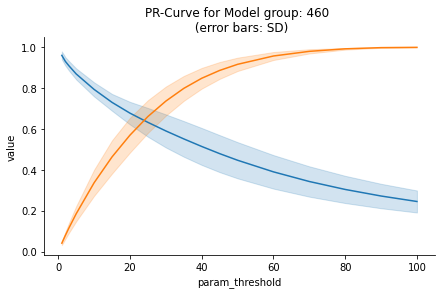

In [59]:
msk1 = model_evaluations['parameter'].str.contains('pct')
msk_prec = model_evaluations['metric'].str.contains('precision')
msk_recall = model_evaluations['metric'].str.contains('recall')

fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(data=model_evaluations[msk1 & msk_prec].sort_values('param_threshold'), x='param_threshold', y='value', ci='sd')
sns.lineplot(data=model_evaluations[msk1 & msk_recall].sort_values('param_threshold'), x='param_threshold', y='value', ci='sd')
sns.despine()
ax.set_title('PR-Curve for Model group: {} \n (error bars: SD)'.format(models.at[0, 'model_group_id']))

#### Features

**How frequently is a feature "important"?**

In [60]:
q = """ select 
            feature, 
            count(*)::float / 13 as pct_times_in_top10_abs
    from train_results.feature_importances 
    where model_id in {} and rank_abs <= 10
    group by feature
    order by count(*) desc
    """.format(tuple(models['model_id']))

num_times_important = pd.read_sql(q, db_conn)

Text(0.5, 1.0, 'Most frequently important features in model group 460')

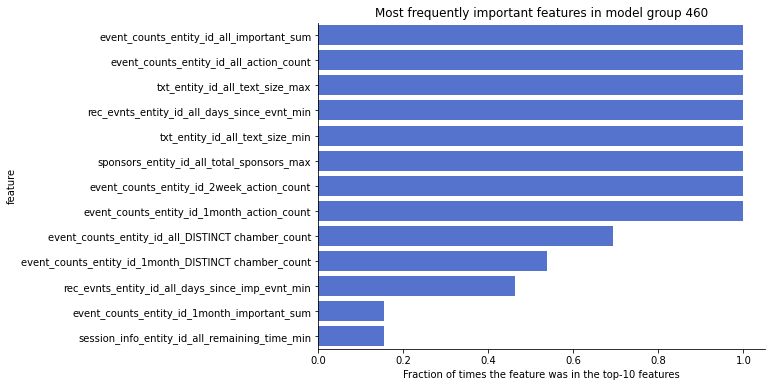

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=num_times_important, y='feature', x='pct_times_in_top10_abs', color='royalblue')
sns.despine()
ax.set_xlabel('Fraction of times the feature was in the top-10 features')
ax.set_title('Most frequently important features in model group {}'.format(models.at[0, 'model_group_id']))

**What's the average rank of the feature?**"

In [39]:
q = """ select 
            feature, 
            avg(rank_abs) as avg_abs_rank,
            avg(rank_pct) as avg_pct_rank,
            max(rank_abs) as worst_rank,
            min(rank_abs) as best_rank
    from train_results.feature_importances 
    where model_id in {}
    group by feature
    order by avg_abs_rank
    """.format(tuple(models['model_id']))

In [40]:
feature_importance_stats = pd.read_sql(q, db_conn)

Text(0.5, 1.0, 'Features with highest avg rank in model group 375')

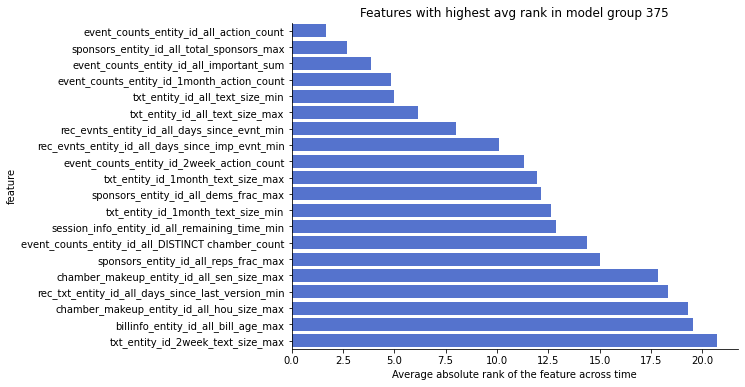

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=feature_importance_stats.iloc[:20], y='feature', x='avg_abs_rank', color='royalblue')
sns.despine()
ax.set_xlabel('Average absolute rank of the feature across time')
ax.set_title('Features with highest avg rank in model group {}'.format(models.at[0, 'model_group_id']))

In [44]:
q = """
    select 
        *
    from train_results.feature_importances 
    where model_id in {} 
""".format(tuple(models['model_id']))

In [45]:
feature_importance_scores = pd.read_sql(q, db_conn)

Text(0.5, 0, 'Average absolute rank of the feature across time')

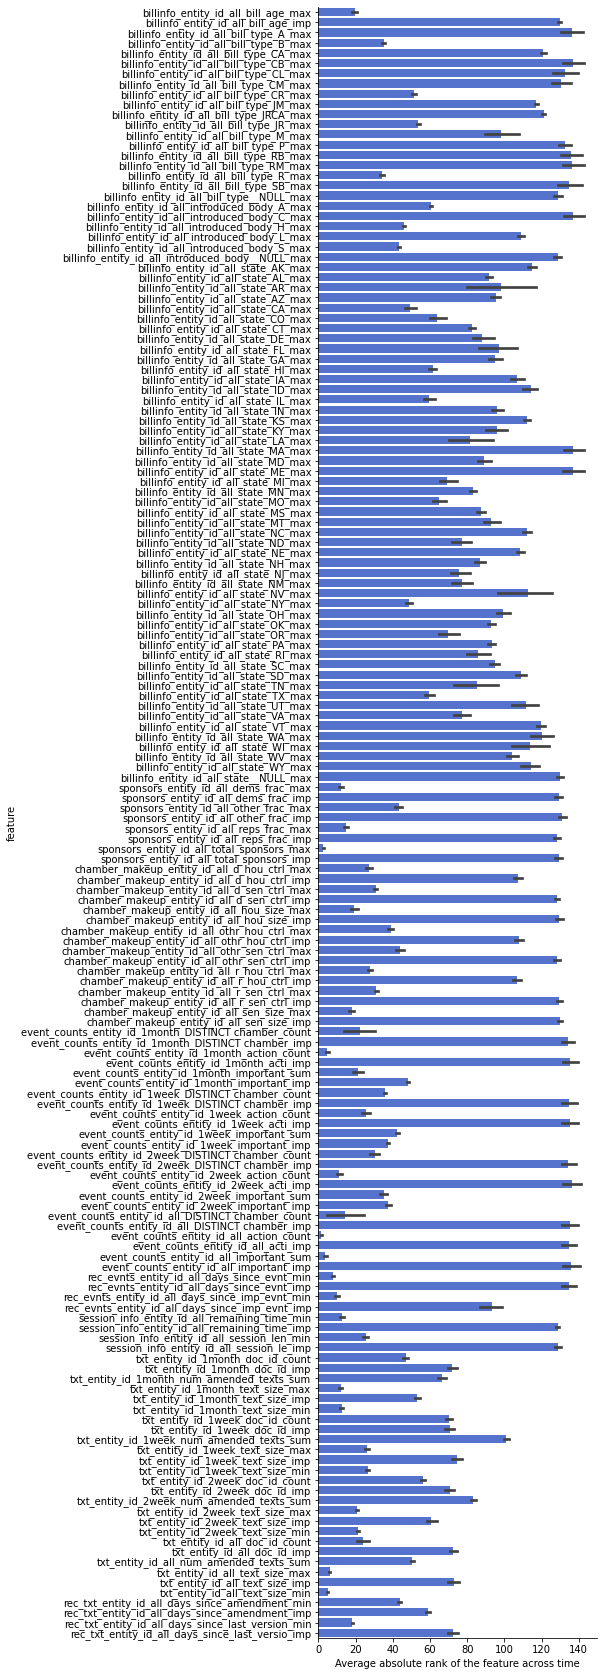

In [53]:
fig, ax = plt.subplots(figsize=(5,30))
sns.barplot(data=feature_importance_scores, y='feature', x='rank_abs', color='royalblue')
sns.despine()
ax.set_xlabel('Average absolute rank of the feature across time')